<a href="https://colab.research.google.com/github/LahiWeer/2330902-ML_CW/blob/master/ML%20models/NN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [13]:
# Step 1: Load the dataset
data_url = 'https://raw.githubusercontent.com/LahiWeer/2330902-ML_CW/refs/heads/master/Preprocessing/resampled_and_original_data.csv'
data = pd.read_csv(data_url)

In [14]:
# Step 2: Inspect the data (Optional)
print(data.head())

   age  job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0   56                0                 0              1               0   
1   57                0                 0              0               0   
2   37                0                 0              0               0   
3   40                0                 0              0               0   
4   56                0                 0              0               0   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0            0                  0             0            0               0   
1            0                  0             1            0               0   
2            0                  0             1            0               0   
3            0                  0             0            0               0   
4            0                  0             1            0               0   

   ...  campaign  pdays  previous  poutcome  emp.var.rate  con

In [15]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61318 entries, 0 to 61317
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                61318 non-null  int64  
 1   job_blue-collar    61318 non-null  int64  
 2   job_entrepreneur   61318 non-null  int64  
 3   job_housemaid      61318 non-null  int64  
 4   job_management     61318 non-null  int64  
 5   job_retired        61318 non-null  int64  
 6   job_self-employed  61318 non-null  int64  
 7   job_services       61318 non-null  int64  
 8   job_student        61318 non-null  int64  
 9   job_technician     61318 non-null  int64  
 10  job_unemployed     61318 non-null  int64  
 11  marital_single     61318 non-null  int64  
 12  marital_married    61318 non-null  int64  
 13  marital_divorced   61318 non-null  int64  
 14  education          61318 non-null  int64  
 15  default            61318 non-null  int64  
 16  housing            613

In [16]:
# Step 3: Separate features (X) and target (y)
# Replace 'target_column_name' with the actual target column name
X = data.drop('y', axis=1)
y = data['y']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Feature Scaling with Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Build and train the Neural Network
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7866 - loss: 0.4456 - val_accuracy: 0.8378 - val_loss: 0.3679
Epoch 2/50
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8364 - loss: 0.3684 - val_accuracy: 0.8406 - val_loss: 0.3574
Epoch 3/50
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8393 - loss: 0.3563 - val_accuracy: 0.8423 - val_loss: 0.3544
Epoch 4/50
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8506 - loss: 0.3441 - val_accuracy: 0.8417 - val_loss: 0.3548
Epoch 5/50
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8513 - loss: 0.3408 - val_accuracy: 0.8433 - val_loss: 0.3489
Epoch 6/50
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8535 - loss: 0.3366 - val_accuracy: 0.8489 - val_loss: 0.3432
Epoch 7/50
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8560 - loss: 0.3313 - val_accuracy: 0.8517 - val_loss: 0.3398
Epoch 8/50
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8552 - loss: 0.3328 - 

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8639 - loss: 0.3292
Test Accuracy: 0.86


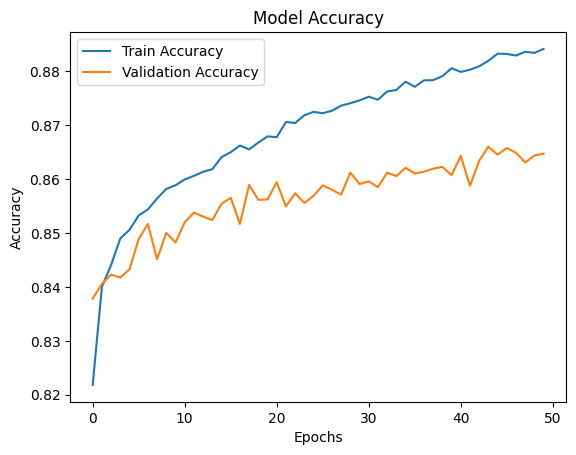

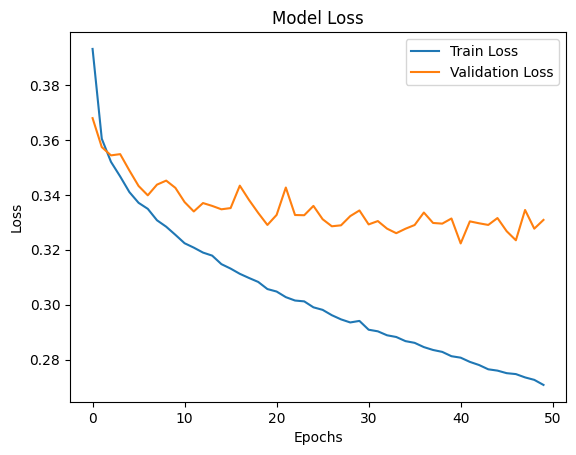

In [18]:
# Plot training history (Optional)
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()